# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor

In [3]:
df = pd.read_csv('/datasets/autos.csv')
df.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [4]:
def df_analyse(df):
    print('Количество параметров и объектов', df.shape)
    print('Количество дубликатов в датасете', df.duplicated().sum())
    print('Количество пропусков в датасете', df.isna().sum().sum())

In [5]:
df.info()
df_analyse(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [6]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


В результате изучения полученных данных, были выявлены следующие особенности:

1. В некоторых объявлений указаны некорректные значения года регистрации автомобиля;
2. В некоторых объявлений указаны некорректные значения мощности (л. с.) автомобиля;
3. Для некоторых автомобилей указана цена 0 евро.

Для начала удалим неинформативные для моделей признаки:

In [7]:
new_df = df.drop(
    ['DateCrawled', 'LastSeen', 'PostalCode',
     'NumberOfPictures', 'DateCreated',
    'RegistrationMonth', ], axis=1)

In [8]:
new_df.info()
df_analyse(new_df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             354369 non-null  int64 
 1   VehicleType       316879 non-null  object
 2   RegistrationYear  354369 non-null  int64 
 3   Gearbox           334536 non-null  object
 4   Power             354369 non-null  int64 
 5   Model             334664 non-null  object
 6   Kilometer         354369 non-null  int64 
 7   FuelType          321474 non-null  object
 8   Brand             354369 non-null  object
 9   Repaired          283215 non-null  object
dtypes: int64(4), object(6)
memory usage: 27.0+ MB
Количество параметров и объектов (354369, 10)
Количество дубликатов в датасете 45040
Количество пропусков в датасете 181077


In [9]:
new_df = new_df.drop_duplicates()
new_df.describe()

,Price,RegistrationYear,Power,Kilometer
count,309329.000000,309329.000000,309329.000000,309329.000000
mean,4486.937196,2004.360105,110.976908,127217.735809
std,4564.852796,92.541399,200.969473,38532.941010
min,0.000000,1000.000000,0.000000,5000.000000
25%,1100.000000,1999.000000,69.000000,125000.000000
50%,2800.000000,2003.000000,105.000000,150000.000000
75%,6500.000000,2008.000000,143.000000,150000.000000
max,20000.000000,9999.000000,20000.000000,150000.000000


**1. Исправим некорректные значения года регистрации автомобиля:**

In [10]:
new_df['RegistrationYear'].unique()

array([1993, 2011, 2004, 2001, 2008, 1995, 1980, 2014, 1998, 2005, 1910,
       2016, 2007, 2009, 2002, 2018, 1997, 1990, 2017, 1981, 2003, 1994,
       1991, 1984, 2006, 1999, 2012, 2010, 2000, 1992, 2013, 1996, 1985,
       1989, 2015, 1982, 1976, 1983, 1973, 1111, 1969, 1971, 1987, 1986,
       1988, 1970, 1965, 1945, 1925, 1974, 1979, 1955, 1978, 1972, 1968,
       1977, 1961, 1960, 1966, 1975, 1963, 1964, 5000, 1954, 1958, 1967,
       1959, 9999, 1956, 3200, 1000, 1941, 8888, 1500, 2200, 4100, 1962,
       1929, 1957, 1940, 3000, 2066, 1949, 2019, 1937, 1951, 1800, 1953,
       1234, 8000, 5300, 9000, 2900, 6000, 5900, 5911, 1933, 1400, 1950,
       4000, 1948, 1952, 1200, 8500, 1932, 1255, 3700, 3800, 4800, 1942,
       7000, 1935, 1936, 6500, 1923, 2290, 2500, 1930, 1001, 9450, 1944,
       1943, 1934, 1938, 1688, 2800, 1253, 1928, 1919, 5555, 5600, 1600,
       2222, 1039, 9996, 1300, 8455, 1931, 1915, 4500, 1920, 1602, 7800,
       9229, 1947, 1927, 7100, 8200, 1946, 7500, 35

In [11]:
new_df.query('1980 > RegistrationYear >= 1961')

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
360,10000,bus,1976,NaN,0,transporter,5000,petrol,volkswagen,NaN
534,4900,convertible,1973,manual,44,kaefer,90000,petrol,volkswagen,no
630,12000,sedan,1969,manual,140,s_klasse,80000,petrol,mercedes_benz,no
650,15000,coupe,1971,NaN,0,NaN,5000,NaN,sonstige_autos,no
981,2900,sedan,1971,auto,90,other,90000,petrol,opel,no
...,...,...,...,...,...,...,...,...,...,...
353910,11500,suv,1976,manual,100,other,150000,petrol,jeep,NaN
353912,800,NaN,1970,NaN,0,other,150000,NaN,trabant,NaN
354037,10500,convertible,1968,manual,54,other,20000,NaN,renault,no
354063,0,NaN,1970,NaN,0,sl,150000,NaN,mercedes_benz,NaN


Отфильтруем данные по наиболее реалистичным данным:

In [12]:
new_df = new_df.query('1960 < RegistrationYear <= 2016')

**2. Исправим  некорректные значения мощности (л. с.) автомобиля:**

<AxesSubplot:>

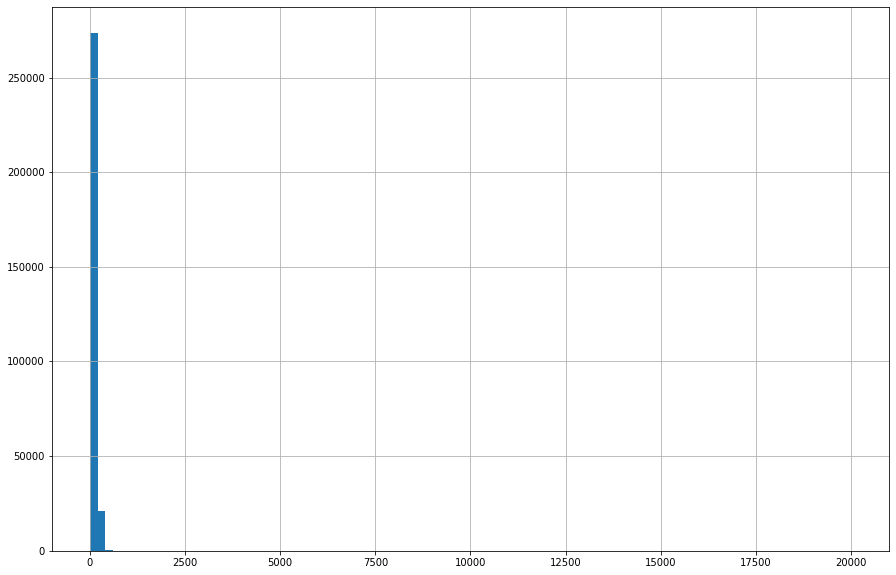

In [13]:
new_df['Power'].hist(bins=100, figsize=(15,10))

<AxesSubplot:>

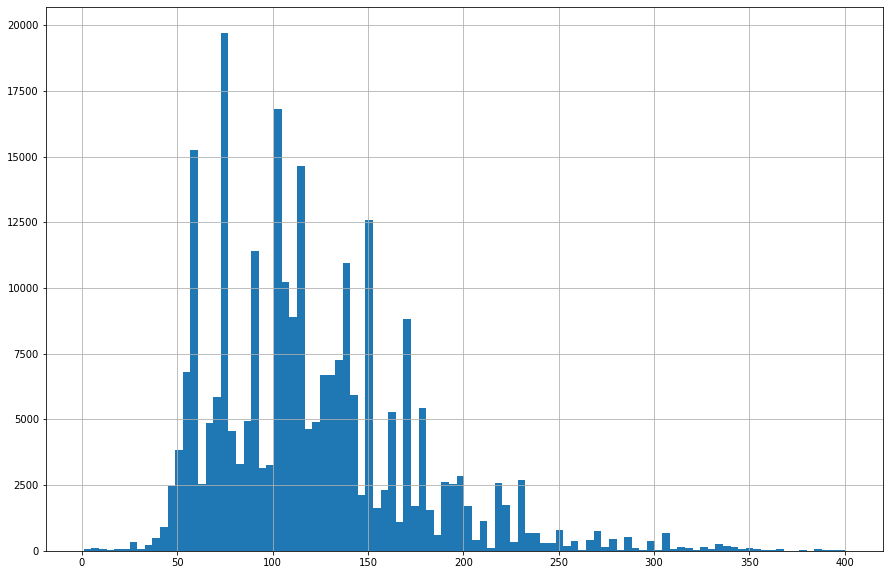

In [14]:
new_df = new_df.query('0 < Power <= 400')
new_df['Power'].hist(bins=100, figsize=(15,10))

**3. Рассмотрим распределение данных по стобцу "Price":**

<AxesSubplot:>

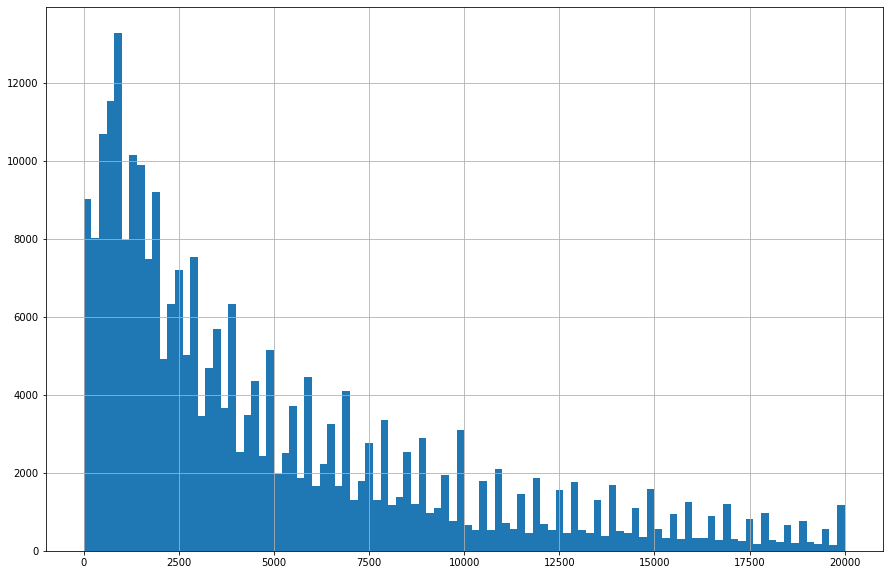

In [15]:
new_df['Price'].hist(bins=100, figsize=(15,10))

In [16]:
new_df['Price'].value_counts()

0        5413
1500     3641
500      3560
2500     3084
1200     3002
         ... 
8211        1
12978       1
9577        1
6583        1
8188        1
Name: Price, Length: 3590, dtype: int64

Для максимального точных и реалистичных анализа и резултатов, удалим значения, равные нулю (при условии сохранения нормального распределения данных):

<AxesSubplot:>

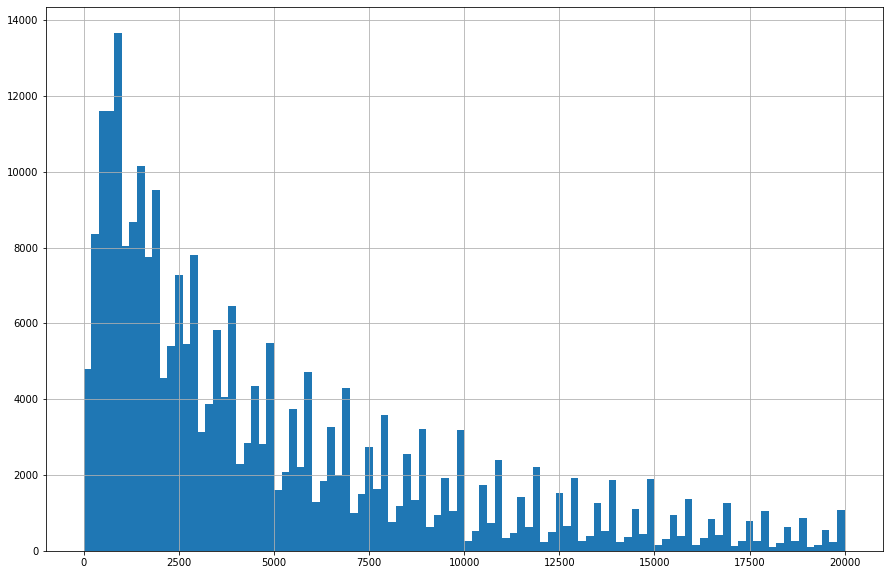

In [17]:
new_df = new_df.query('Price != 0')
new_df['Price'].hist(bins=100, figsize=(15,10))

**4. Булевый тип**

Приведём данные в столбцах "Gearbox" и "Repaired" к булевуму типу. Так моделям будет легче работать с данными:

In [18]:
new_df['Gearbox'] = new_df['Gearbox'].replace({'manual': True, 'auto': False})
new_df['Repaired'] = new_df['Repaired'].replace({'yes': True, 'no': False})
new_df.rename(columns={'Gearbox': 'Gearbox_manual'}, inplace=True)

Заменим пропуски на наиболее часто встречающиеся значения:

In [19]:
new_df.fillna({'Gearbox_manual': True, 'Repaired':False}, inplace=True)

**5. Заполнение пропусков**

Заменим пропуски на наиболее часто встречающиеся значения:

In [20]:
new_df.fillna({'VehicleType':'sedan', 'FuelType':'petrol', 'Model':'unknown'}, inplace=True)

In [21]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 256964 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             256964 non-null  int64 
 1   VehicleType       256964 non-null  object
 2   RegistrationYear  256964 non-null  int64 
 3   Gearbox_manual    256964 non-null  bool  
 4   Power             256964 non-null  int64 
 5   Model             256964 non-null  object
 6   Kilometer         256964 non-null  int64 
 7   FuelType          256964 non-null  object
 8   Brand             256964 non-null  object
 9   Repaired          256964 non-null  bool  
dtypes: bool(2), int64(4), object(4)
memory usage: 18.1+ MB


## Обучение моделей

### Разделим данные на три выборки

In [22]:
features = new_df.drop('Price', axis=1)
target = new_df['Price']

features_train, features_valid_and_test, target_train, target_valid_and_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid_and_test, target_valid_and_test, test_size=0.5, random_state=12345)

### Кодирование выборок

In [23]:
# прямое кодирование (для линейных моделей)
features_train_ohe = pd.get_dummies(features_train, drop_first=True)
features_valid_ohe = pd.get_dummies(features_valid, drop_first=True)
features_test_ohe = pd.get_dummies(features_test, drop_first=True)
# после прямого кодирования кол-во признаков в выборках будет отличаться
# поэтому стоит удалить лишние признаки в каждой выборке

# Найдем общие признаки между обучающей, валидационной и тестовой выборками
common_columns = set(features_train_ohe.columns) & set(features_valid_ohe.columns) & set(features_test_ohe.columns)

# Оставим в каждой выборке только общие признаки
features_train_ohe = features_train_ohe[list(common_columns)]
features_valid_ohe = features_valid_ohe[list(common_columns)]
features_test_ohe = features_test_ohe[list(common_columns)]

In [24]:
# порядковое кодирование
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=9999)
cat_columns = ['VehicleType','FuelType','Brand','Model']
encoder.fit(features_train[cat_columns])

features_train_ord = features_train.copy()
features_valid_ord = features_valid.copy()
features_test_ord = features_test.copy()

features_train_ord[cat_columns] = encoder.transform(features_train_ord[cat_columns])
features_valid_ord[cat_columns] = encoder.transform(features_valid_ord[cat_columns])
features_test_ord[cat_columns] = encoder.transform(features_test_ord[cat_columns])

### Масштабирование численных признаков для линейных моделей

In [25]:
numeric = ['RegistrationYear', 'Power', 'Kilometer']

scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

pd.options.mode.chained_assignment = None

/tmp/ipykernel_31/4174547328.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/4174547328.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

### Модель LGBMRegressor

In [26]:
# Определение функции RMSE
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Создание объекта скорера с использованием функции RMSE
rmse_scorer = make_scorer(rmse, greater_is_better=False)

In [46]:
%%time

param_grid = {
    'num_leaves': [31, 50, 100],
    'learning_rate': [0.01, 0.1, 1],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

model = LGBMRegressor()
grid_search = GridSearchCV(model, param_grid, cv=5, scoring=rmse_scorer)
grid_search.fit(features_train_ord, target_train)

CPU times: user 1h 28min 18s, sys: 45.9 s, total: 1h 29min 4s
Wall time: 1h 29min 35s


GridSearchCV(cv=5, estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [3, 5, 7], 'n_estimators': [50, 100, 200],
                         'num_leaves': [31, 50, 100]},
             scoring=make_scorer(rmse, greater_is_better=False))

In [49]:
best_lgbm = grid_search.best_params_
best_lgbm

{'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200, 'num_leaves': 100}

In [53]:
%%time
model = LGBMRegressor(learning_rate=0.1, max_depth=7, n_estimators=200, num_leaves=100)
model.fit(features_train_ord, target_train)

CPU times: user 7.98 s, sys: 28.9 ms, total: 8.01 s
Wall time: 8.03 s


LGBMRegressor(max_depth=7, n_estimators=200, num_leaves=100)

### Модель LinearRegression

In [35]:
%%time
model = LinearRegression()
model.fit(features_train_ohe, target_train)

CPU times: user 10.1 s, sys: 4.79 s, total: 14.9 s
Wall time: 15 s


LinearRegression()

In [36]:
%%time
model_prediction = model.predict(features_valid_ohe)

CPU times: user 646 ms, sys: 242 ms, total: 888 ms
Wall time: 960 ms


In [37]:
RMSE = (mean_squared_error(target_valid, model_prediction))** 0.5
print('RMSE для линейной модели на валидационной выборке:', RMSE)

RMSE для линейной модели на тестовой выборке: 2640.03098428405


### Модель DecisionTreeRegressor

In [38]:
%%time
model = DecisionTreeRegressor(criterion='mse', max_depth=13, random_state=12345) 
model.fit(features_train_ord, target_train)

CPU times: user 378 ms, sys: 25.9 ms, total: 404 ms
Wall time: 403 ms


DecisionTreeRegressor(max_depth=13, random_state=12345)

In [39]:
%%time
model_prediction = model.predict(features_valid_ord)

CPU times: user 33.7 ms, sys: 1.27 ms, total: 35 ms
Wall time: 33.5 ms


In [40]:
RMSE = (mean_squared_error(target_valid, model_prediction))** 0.5
print('RMSE для случайного леса на валидационной выборке:', RMSE)

RMSE для случайного леса на тестовой выборке: 1917.3013849582255


## Анализ моделей

In [56]:
analysis_model = [['8.03 s', '906 ms', 1623.865],
        ['15 s', '960 ms', 2640.03],
        ['403 ms', '33.5 ms', 1917.3]]
        
model_types = ['LGBMRegressor', 'LinearRegression', 'DecisionTreeRegressor']


pd.DataFrame(data=analysis_model, index=model_types, columns=['fit_time', 'predict_time', 'RMSE'])

,fit_time,predict_time,RMSE
LGBMRegressor,8.03 s,906 ms,1623.865
LinearRegression,15 s,960 ms,2640.030
DecisionTreeRegressor,403 ms,33.5 ms,1917.300


## Тестирование лучшей модели

In [27]:
model = LGBMRegressor(learning_rate=0.1, max_depth=7, n_estimators=200, num_leaves=100)
model.fit(features_train_ord, target_train)

model_prediction = model.predict(features_test_ord)
RMSE = (mean_squared_error(target_test, model_prediction))** 0.5
print('RMSE для случайного леса на тестовой выборке:', RMSE)

RMSE для случайного леса на тестовой выборке: 1620.2067124896068


## Вывод

Полученные данные подверглись обработки для обеспечения возможности модели адекватно работать с признаками. Подробнее шаги были описаны в п.1

На этапах обучения и анализа моделей были выявлены две наиболее подходящие модели для заказчика:

1. LGBMRegressor показал наилучший показатель RMSE при самых оптимальных параметрах, однако время выполнения процессов уступает второй подходящей модели. При этом время обучения и предсказания модели остаётся в пределах разумного;
2. DecisionTreeRegressor в разы быстрее завершила процессы обучения и предсказания, по сравнению с первой подходящей модели. Однако значение RMSE превышает значение RMSE LGBMRegressor на 300 единиц.

В связи с этим, заказчику рекомендуется воспользоваться моделью LGBMRegressor, подходящая по всем запрашиваемым условиям. Однако если же выполнение предсказания и обучения необходимо макимально быстрое, подойдёт использование модели DecisionTreeRegressor, но в таком случае нужно быть готовым пожертвовать более качественной работой модели (более низким показателем RMSE)